In [9]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

### Agents Initialization

In [ ]:
class Sensor:
    def __init__(self, position):
        self.position = position  # (x, y) coordinates
        self.data = random.random()  # Simulated sensor data

    def generate_data(self):
        self.data = random.random()

class Alice:
    def __init__(self, id, position, power=1.0):
        self.id = id  # Unique identifier for Alice
        self.position = position  # (x, y) coordinates
        self.power = power  # Transmission power
        self.collected_data = None  # Data collected from Sensors
        self.aoi = 0  # Age of Information
        self.total_power_consumption = 0  # Track total power consumed in an episode
        self.steps_taken = 0  # Track the number of steps Alice has taken

    def adjust_power(self, new_power):
        self.total_power_consumption += new_power  # Add the new power value to total consumption
        self.power = max(0, new_power)  # Ensure power is non-negative

    def collect_data(self, sensors, collection_range=15):
        for sensor in sensors:
            distance = np.linalg.norm(np.array(self.position) - np.array(sensor.position))
            if distance <= collection_range:
                self.collected_data = sensor.data
                sensor.generate_data()  # Simulate new data generation
                self.aoi = 0  # Reset AoI when data is collected
                return  # Stop after collecting from one sensor
        # If no sensor is found, AoI increments
        self.aoi += 1  # Increase AoI over time when data is not collected

    def send_data(self, bob, current_time, transmission_range=15):
        """Send data to Bob if within range."""
        if self.collected_data is None:
            return

        distance = np.linalg.norm(np.array(self.position) - np.array(bob.position))
        if distance <= transmission_range:
            bob.receive_data(self.collected_data)
            self.aoi = 0  # Reset AoI since data was sent
            self.collected_data = None  # Clear collected data

    def get_state(self, sensors, bobs, wardens):
        """Get the current state representation for Alice."""
        sensor_distances = [np.linalg.norm(np.array(self.position) - np.array(sensor.position)) for sensor in sensors]
        bob_distances = [np.linalg.norm(np.array(self.position) - np.array(bob.position)) for bob in bobs]
        warden_distances = [np.linalg.norm(np.array(self.position) - np.array(warden.position)) for warden in wardens]

        # State includes position, power, AoI, and proximity to Sensors, Bobs, and Wardens
        state = (
            self.position[0],  # x-coordinate
            self.position[1],  # y-coordinate
            self.power,         # Transmission power level
            self.aoi,           # Age of Information
            int(self.collected_data is not None),  # 1 if Alice has data, else 0
            *sensor_distances,  # Distances to Sensors
            *bob_distances,     # Distances to Bobs
            *warden_distances   # Distances to Wardens
        )
        return state

    def perform_action(self, action, sensors, bobs):
        # Action is expected to be a tuple (power_adjustment, movement, transmission_target)
        power_adjustment, movement, transmission_target = action

        # Adjust power
        self.adjust_power(self.power + power_adjustment)

        # Move based on the RL action (movement)
        self.move(movement)

        # Transmit data to the specified Bob (if valid)
        if transmission_target < len(bobs):
            self.send_data(bobs[transmission_target], current_time=0)  # Example current_time

    def move(self, direction):
        # Define movement options
        if direction == "UP":
            self.position = (self.position[0], self.position[1] + 1)
        elif direction == "DOWN":
            self.position = (self.position[0], self.position[1] - 1)
        elif direction == "LEFT":
            self.position = (self.position[0] - 1, self.position[1])
        elif direction == "RIGHT":
            self.position = (self.position[0] + 1, self.position[1])
        # Ensure the position is within the environment bounds (e.g., within map size)
        self.position = (max(0, min(self.position[0], 100)), max(0, min(self.position[1], 100)))  # Example bounds
        
    def reset(self):
        self.total_power_consumption = 0  # Reset total power consumption at the start of each episode
        self.steps_taken = 0  # Reset steps taken counter

class Bob:
    def __init__(self, position):
        self.position = position  # (x, y) coordinates
        self.received_data = None  # Latest data received

    def receive_data(self, data):
        self.received_data = data

class Warden:
    def __init__(self, position):
        self.position = position  # (x, y) coordinates

    def detect(self, alice, detection_threshold=0.5):
        distance = np.linalg.norm(np.array(alice.position) - np.array(self.position))
        detection_prob = np.exp(-distance / (alice.power + 1))  # Simplified detection model
        return detection_prob > detection_threshold
   

### Environment Initialization

In [ ]:
class Environment:
    def __init__(self, map_size, num_alices, num_sensors, num_bobs, num_wardens, seed=42):
        self.map_size = map_size
        self.num_alices = num_alices
        self.num_sensors = num_sensors
        self.num_bobs = num_bobs
        self.num_wardens = num_wardens
        self.current_time = 0  # Current simulation time step
        self.max_time_steps = 100  # Maximum steps per episode

        # Set the random seed for reproducibility
        random.seed(seed)
        np.random.seed(seed)

        # Initialize entities
        self.alices = self.distribute_alices_evenly()
        self.sensors = self.distribute_sensors_randomly()
        self.bobs = self.distribute_bobs_randomly()
        self.wardens = self.distribute_wardens_randomly()

        # Initialize metrics trackers
        self.covert_throughput = 0  # Successful transmissions without detection
        self.detection_errors = 0  # Detection errors (false alarms + missed detections)
        self.total_aoi = 0  # Total AoI for all Alices

    def reset(self):
        self.current_time = 0
        self.covert_throughput = 0
        self.detection_errors = 0
        self.total_aoi = 0
        self.alices = self.distribute_alices_evenly()
        self.sensors = self.distribute_sensors_randomly()
        self.bobs = self.distribute_bobs_randomly()
        self.wardens = self.distribute_wardens_randomly()
        # Return the initial states of all Alices
        return [alice.get_state(self.sensors, self.bobs, self.wardens) for alice in self.alices]

    def step(self, actions):
        total_reward = 0
        states_after_step = []
        done = False

        # Loop through each Alice to process the action
        for i, alice in enumerate(self.alices):
            # Perform the action assigned to this Alice
            action = actions[i]

            # Ensure action is a tuple, if not convert it to a tuple with default values
            if not isinstance(action, tuple):
                action = (0, 0, 0)  # Default tuple (power_adjustment, movement, transmission_target)
            
            # Collect data from nearby sensors before performing action
            alice.collect_data(self.sensors)  # Collect data from sensors
            
            # Perform the action with the updated action format
            alice.perform_action(action, self.sensors, self.bobs)

            # Check for detection by Wardens
            detected = any(warden.detect(alice) for warden in self.wardens)
    
            # Track metrics
            if alice.collected_data is not None and not detected:
                self.covert_throughput += 1  # Count successful transmissions

            if detected:
                self.detection_errors += 1  # Count detection errors

            self.total_aoi += alice.aoi  # Track AoI

            # Calculate reward for Alice based on actions and detection
            reward = self.calculate_reward(alice, detected)
            total_reward += reward

            # Get the updated state for Alice after the action
            state = alice.get_state(self.sensors, self.bobs, self.wardens)
            states_after_step.append(state)

        self.current_time += 1
        if self.current_time >= self.max_time_steps:
            done = True

        return states_after_step, total_reward, done

    def calculate_metrics(self):
        # Calculate the average AoI for the episode
        avg_aoi = self.total_aoi / self.num_alices if self.num_alices else 0
        # Compute detection error probability
        detection_error_prob = self.detection_errors / self.max_time_steps if self.max_time_steps else 0

        return self.covert_throughput, detection_error_prob, avg_aoi
    
    def distribute_alices_evenly(self):
        alices = []
        positions = [
            (35, 35), (35, 65), (65, 35), (65, 65)  # Example positions for up to 4 Alices
        ]
        for i, pos in enumerate(positions[:self.num_alices]):
            alices.append(Alice(i + 1, pos))
        return alices

    def distribute_sensors_randomly(self):
        sensors = []
        for _ in range(self.num_sensors):
            x = random.randint(25, self.map_size - 25)
            y = random.randint(25, self.map_size - 25)
            sensors.append(Sensor((x, y)))
        return sensors

    def distribute_bobs_randomly(self):
        bobs = []
        for _ in range(self.num_bobs):
            x = random.randint(25, self.map_size - 25)
            y = random.randint(25, self.map_size - 25)
            bobs.append(Bob((x, y)))
        return bobs

    def distribute_wardens_randomly(self):
        wardens = []
        for _ in range(self.num_wardens):
            x = random.randint(25, self.map_size - 25)
            y = random.randint(25, self.map_size - 25)
            wardens.append(Warden((x, y)))
        return wardens

    def calculate_reward(self, alice, detected):
        reward = 0

        # Reward for collecting data
        if alice.collected_data is not None:
            reward += 10  # Example reward value for collecting data

        # Reward for successful transmission (without detection)
        if alice.collected_data is None and not detected:
            reward += 20  # Alice transmitted successfully without detection

        # Penalty for being detected by the Warden
        if detected:
            reward -= 30  # Penalty for detection (e.g., Alice got caught)

        # Penalty for Age of Information (AoI)
        reward -= alice.aoi * 0.1  # Penalize AoI; the more outdated the data, the worse the reward

        # Penalty for unnecessary power usage
        reward -= alice.power * 0.5  # Penalize for excessive power usage

        return reward


### QLearningAgent Initialization

In [ ]:
class QLearningAgent:
    def __init__(self, num_actions, state_dim):
        self.num_actions = num_actions  # Number of actions Alice can take
        self.state_dim = state_dim  # Dimensions of state space (number of features in the state)
        
        # Initialize the Q-table (state-action values) as a defaultdict of zeros
        self.q_table = defaultdict(lambda: np.zeros(num_actions))

    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate
    
    def set_discount_factor(self, discount_factor):
        self.discount_factor = discount_factor
    
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def get_learning_rate(self):
        return self.learning_rate
    
    def get_discount_factor(self):
        return self.discount_factor
    
    def get_epsilon(self):
        return self.epsilon

    def action_to_index(self, action, num_bobs):
        power_adjustment, movement, transmission_target = action

        # Normalize the power_adjustment and movement to positive integers
        power_adjustment_idx = power_adjustment + 1  # Now -1 -> 0, 0 -> 1, 1 -> 2
        movement_idx = movement + 1  # Now -1 -> 0, 0 -> 1, 1 -> 2
        
        # Calculate the index for the action in the Q-table
        action_index = power_adjustment_idx * 3 * num_bobs + movement_idx * num_bobs + transmission_target

        # Ensure the action index does not exceed the number of actions
        if action_index >= self.num_actions:
            raise ValueError(f"Action index {action_index} exceeds the number of available actions: {self.num_actions}")

        return action_index

    def choose_action(self, state, bobs):
        if random.uniform(0, 1) < self.epsilon:
            # Exploration: Choose a random action
            power_adjustment = random.choice([-1, 0, 1])  # Adjust power by -1, 0, or +1
            movement = random.choice([-1, 0, 1])  # Adjust movement in x or y direction
            transmission_target = random.randint(0, len(bobs) - 1)  # Randomly select a Bob to transmit to
        else:
            # Exploitation: Choose the best known action (based on max Q-value for current state)
            action_index = np.argmax(self.q_table[tuple(state)])  # Get index of the best action
            power_adjustment, movement, transmission_target = self.index_to_action(action_index, len(bobs))  # Convert index to action
        
        action = (power_adjustment, movement, transmission_target)
        return action

    def index_to_action(self, index, num_bobs):
        power_adjustment_idx = index // (3 * num_bobs)  # Find the power adjustment index
        movement_idx = (index % (3 * num_bobs)) // num_bobs  # Find the movement index
        transmission_target = index % num_bobs  # Find the transmission target

        # Convert indices back to values
        power_adjustment = power_adjustment_idx - 1  # Convert to range [-1, 0, 1]
        movement = movement_idx - 1  # Convert to range [-1, 0, 1]
        
        return (power_adjustment, movement, transmission_target)
    
    def update_q_value(self, state, action, reward, next_state, num_bobs):
        # Ensure state and next_state are tuples
        state = tuple(state)
        next_state = tuple(next_state)
        
        # Find the best action for the next state
        best_next_action = np.argmax(self.q_table[next_state])  # Best action for next state
        
        # Convert the action tuple to an index
        action_index = self.action_to_index(action, num_bobs)

        # Q-learning update rule
        self.q_table[state][action_index] = (self.q_table[state][action_index] + self.learning_rate * 
                                             (reward + self.discount_factor * self.q_table[next_state][best_next_action] - self.q_table[state][action_index]))

    def reset(self):
        pass

### Definining Parameters for Training

In [27]:
# Step 2: Define the environment and agent parameters
map_size = 100
num_alices = 5
num_sensors = 10
num_bobs = 2
num_wardens = 5
env = Environment(map_size, num_alices, num_sensors, num_bobs, num_wardens, seed=42)

# State and action dimensions for the QLearning agent
state_dim = 4 + 1 + num_sensors + num_bobs + num_wardens  # 4 for position, 1 for power, sensor_distances, bob_distances, warden_distances
num_actions = 3 * 3 * num_bobs  # 3 power adjustment actions (-1, 0, +1), num_bobs choices for transmission

# Initialize the QLearningAgent
agent = QLearningAgent(num_actions=num_actions, state_dim=state_dim)
# Set learning rate, discount factor, and epsilon externally
agent.set_learning_rate(0.001)
agent.set_discount_factor(0.99)
agent.set_epsilon(0.1)

### Training Loop

In [28]:
num_episodes = 1000
reward_history = []
covert_throughput_history = []
detection_error_prob_history = []
aoi_history = []
avg_power_consumption_history = []

# Parameters for decay
epsilon_decay_rate = 0.99  # Decay rate for epsilon (exploration factor)
learning_rate_decay_rate = 0.995  # Decay rate for learning rate
min_epsilon = 0.01  # Minimum value for epsilon (ensures some exploration)
min_learning_rate = 0.0001  # Minimum value for learning rate

for episode in range(num_episodes):
    # Reset the environment at the start of each episode
    states = env.reset()  # This will get the initial states of all Alice agents
    total_reward = 0
    done = False

    while not done:
        actions = []
        next_states = []
        
        # Collect actions from each Alice (agent will decide based on state)
        for i, alice in enumerate(env.alices):
            state = alice.get_state(env.sensors, env.bobs, env.wardens)  # Get the current state of Alice

            # Convert state to a tuple if it's a list (to ensure it's hashable)
            state_tuple = tuple(state)  # Convert the state to a tuple

            # Get the action from the Q-learning agent based on the current state
            action = agent.choose_action(state_tuple, env.bobs)  # Choose an action (power_adjustment, movement, transmission_target)
            actions.append(action)

        # Step through the environment with the chosen actions
        next_states, reward, done = env.step(actions)  # Apply the actions and get new states, reward, and termination status

        # Update Q-values for each Alice (agent) based on the observed reward
        for i, alice in enumerate(env.alices):
            state = alice.get_state(env.sensors, env.bobs, env.wardens)
            state_tuple = tuple(state)  # Convert state to a tuple
            agent.update_q_value(state_tuple, actions[i], reward, next_states[i], len(env.bobs))  # Update Q-values with the reward and next state
        
        total_reward += reward
        
        # If episode reaches maximum time steps, stop the episode
        if done:
            break
    
    # Track metrics at the end of each episode
    covert_throughput, detection_error_prob, avg_aoi = env.calculate_metrics()
    covert_throughput_history.append(covert_throughput)
    detection_error_prob_history.append(detection_error_prob)
    aoi_history.append(avg_aoi)
    reward_history.append(total_reward)

    # Track average power consumption
    total_power_consumption = sum([alice.total_power_consumption for alice in env.alices])
    avg_power_consumption = total_power_consumption / len(env.alices)  # Calculate average power consumption for the episode
    avg_power_consumption_history.append(avg_power_consumption)
    
    print(f"\nEpisode {episode + 1}/{num_episodes}- Total Reward: {total_reward}")

    # Apply epsilon decay
    epsilon = max(min_epsilon, agent.get_epsilon() * epsilon_decay_rate)  # Decay epsilon for exploration
    agent.set_epsilon(epsilon)

    # Apply learning rate decay
    learning_rate = max(min_learning_rate, agent.get_learning_rate() * learning_rate_decay_rate)  # Decay learning rate
    agent.set_learning_rate(learning_rate)


Episode 1/1000- Total Reward: 405.0

Episode 2/1000- Total Reward: 2761.0

Episode 3/1000- Total Reward: 3477.0

Episode 4/1000- Total Reward: 3016.5

Episode 5/1000- Total Reward: 2232.0

Episode 6/1000- Total Reward: 649.5

Episode 7/1000- Total Reward: 936.5

Episode 8/1000- Total Reward: 1392.5

Episode 9/1000- Total Reward: 4444.500000000001

Episode 10/1000- Total Reward: 1239.0

Episode 11/1000- Total Reward: 867.0

Episode 12/1000- Total Reward: 1935.5

Episode 13/1000- Total Reward: 1150.0

Episode 14/1000- Total Reward: 937.5

Episode 15/1000- Total Reward: 4138.5

Episode 16/1000- Total Reward: 1608.0

Episode 17/1000- Total Reward: 2745.0

Episode 18/1000- Total Reward: 1057.5

Episode 19/1000- Total Reward: 907.5000000000001

Episode 20/1000- Total Reward: 624.0

Episode 21/1000- Total Reward: 2114.5

Episode 22/1000- Total Reward: 3070.5

Episode 23/1000- Total Reward: 2883.5

Episode 24/1000- Total Reward: 1831.5

Episode 25/1000- Total Reward: 2565.0

Episode 26/1000- 

### Visualization

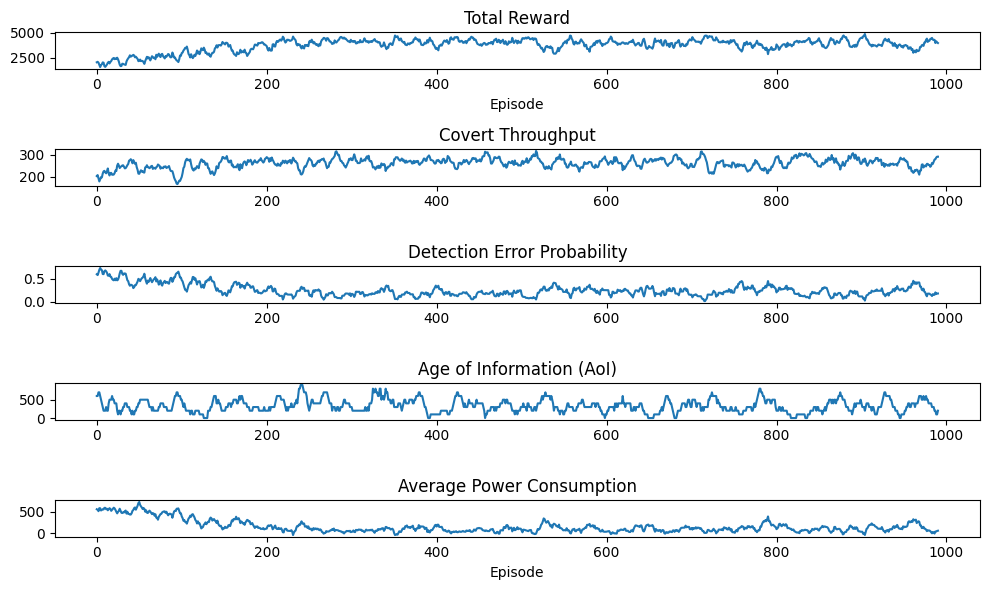

In [29]:
def moving_average(data, window_size=10):
    """Applies a simple moving average."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# After training, plot the performance metrics
plt.figure(figsize=(10, 6))

# Plotting the moving average of the rewards
smoothed_rewards = moving_average(reward_history, window_size=10)
plt.subplot(5, 1, 1)
plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.title('Total Reward')

# Covert Throughput Plot
smoothed_throughput = moving_average(covert_throughput_history, window_size=10)
plt.subplot(5, 1, 2)
plt.plot(smoothed_throughput)
plt.title('Covert Throughput')

# Detection Error Probability Plot
smoothed_detection_prob = moving_average(detection_error_prob_history, window_size=10)
plt.subplot(5, 1, 3)
plt.plot(smoothed_detection_prob)
plt.title('Detection Error Probability')

# Age of Information Plot
smoothed_aoi_history = moving_average(aoi_history, window_size=10)
plt.subplot(5, 1, 4)
plt.plot(smoothed_aoi_history)
plt.title('Age of Information (AoI)')

# Plotting the moving average of the power consumption
smoothed_power_consumption = moving_average(avg_power_consumption_history, window_size=10)
plt.subplot(5, 1, 5)
plt.plot(smoothed_power_consumption)
plt.xlabel('Episode')
plt.title('Average Power Consumption')


plt.tight_layout()
plt.show()